# Контрольная работа. Kinopoisk


### Сроки сдачи контрольной

Дата выдачи: 14.12.2016

Крайняя дата сдачи: 21.12.2016

Выслать результат нужно на lapucki@tut.by. В высылаемом архиве должно быть два файла: result.csv и DA_KP_Surname.ipynb.


### Основное задание (6 баллов)

Дана база данных фильмов с kinopoisk.ru (train_data.csv). Требуется построить модель для прогнозирования рейтинга фильмов на Кинопоиске. Целевая переменная - kp_rating.

В качестве ответа требуется выслать файл result.csv, содержащий полученные значения kp_rating для данных из test_data.csv, а также исходный код.

В качестве метрики для проверки буду использовать Mean absolute error.

### Доп. задания (по 2 балла)

1. Постройте графики зависимости рейтинга фильма (kp_rating) от его популярности (kp_rating_count) и бюджета (budget). Объясните результат.
2. Какие жанры фильмов чаще всего встречаются вместе? Постройте Heatmap диаграмму.

---

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib 

Using matplotlib backend: Qt4Agg


In [ ]:
train = pd.read_csv('train_data.csv', encoding = 'cp1251')
test = pd.read_csv('test_data.csv', encoding = 'cp1251')

In [ ]:
train.head()

## Первичный анализ

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25491 entries, 0 to 25490
Data columns (total 13 columns):
movie_id             25491 non-null int64
name_rus             25491 non-null object
kp_rating            25490 non-null float64
movie_duration       25491 non-null object
kp_rating_count      25490 non-null float64
movie_year           25491 non-null int64
imdb_rating          23163 non-null float64
imdb_rating_count    23163 non-null float64
genres               25411 non-null object
countries            25491 non-null object
budget               7677 non-null object
critics_rating       8041 non-null float64
name_eng             20282 non-null object
dtypes: float64(5), int64(2), object(6)
memory usage: 2.5+ MB


Очевидно, что рейтинг IMDB будет сильно коррелировать с рейтиногом кинопоиска (целевая переменная). Поэтому удалим из выборки значения со значением NaN в поле imdb_rating.  

In [11]:
X_train = train[~np.isnan(train.imdb_rating)]
X_test = test[~np.isnan(test.imdb_rating)]

In [12]:
np.corrcoef(X_train.kp_rating, X_train.imdb_rating)

array([[ 1.        ,  0.80859332],
       [ 0.80859332,  1.        ]])

Посмотрим различную статистику данных

In [14]:
X_train.describe()

C:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,movie_id,kp_rating,kp_rating_count,movie_year,imdb_rating,imdb_rating_count,critics_rating
count,23163.000000,23163.000000,23163.000000,23163.000000,23163.000000,2.316300e+04,8041.000000
mean,277170.389932,6.603837,5124.306048,1996.825239,6.391832,1.701415e+04,60.654894
std,266293.087694,1.150269,18471.136488,18.134132,1.294442,6.190485e+04,28.701733
min,299.000000,1.102000,100.000000,1911.000000,1.200000,5.000000e+00,0.000000
25%,35596.500000,6.065000,184.000000,1990.000000,5.700000,4.410000e+02,NaN
50%,220050.000000,6.818000,420.000000,2004.000000,6.600000,1.737000e+03,NaN
75%,477350.000000,7.415000,1800.000000,2010.000000,7.300000,7.178000e+03,NaN
max,965633.000000,9.120000,401542.000000,2016.000000,9.500000,1.572615e+06,100.000000


Скорее всего с целевой переменной сильно связан признак "Рейтинг Критиков" (critics_rating). Но в данном поле много (~$75\%$) пропущенных значений, поэтому этот признак придется исключить.

In [18]:
del X_train['critics_rating']

In [20]:
del X_test['critics_rating']

Посмотрим на корреляционную матрицу

In [23]:
X_train.corr()

,movie_id,kp_rating,kp_rating_count,movie_year,imdb_rating,imdb_rating_count
movie_id,1.000000,-0.158913,-0.038852,0.616495,-0.030128,-0.075563
kp_rating,-0.158913,1.000000,0.168471,-0.239794,0.808593,0.169829
kp_rating_count,-0.038852,0.168471,1.000000,0.085195,0.136802,0.842318
movie_year,0.616495,-0.239794,0.085195,1.000000,-0.226636,0.053173
imdb_rating,-0.030128,0.808593,0.136802,-0.226636,1.000000,0.171200
imdb_rating_count,-0.075563,0.169829,0.842318,0.053173,0.171200,1.000000


Видим, что действительно признак imdb_rating оказывает сильное влияние на kp_rating. Есть ещё небольшая корреляция целевой переменной с признаком imdb_rating_count. По этих двум признакам построим baseline-модель.

## Baseline

Мы решаем задачу восстановления регрессии. В качестве базовой модели используем обычную Линейную Регрессию.

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_absolute_error

In [48]:
X_base = X_train[['kp_rating_count', 'imdb_rating']]
y_base = X_train['kp_rating']

Т.к. как модель линейная, то выполним нормировку данных

In [58]:
from sklearn.preprocessing import scale

X_base = scale(X_base)

In [59]:
# Splitting data for model validation

x_train, x_test, y_train, y_test = train_test_split(X_base, y_base, test_size=0.4, random_state=2016)

In [60]:
# Our basic model

lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [61]:
# Scoring

y_pred = lr.predict(x_test)
score = mean_absolute_error(y_test, y_pred)
print("Средняя абсолютная ошибка на контрольной выборке для базовой модели: %.5f" %score)

Средняя абсолютная ошибка на контрольной выборке для базовой модели: 0.49769


Ок, теперь есть с чем сравнивать. Приступим к самой интересной части -- feature engineering.

## Генерация признаков

Сначала вынесем из датасета целевую переменную

In [64]:
rating = X_train['kp_rating']

del X_train['kp_rating']
del X_test['kp_rating']

In [65]:
X_train.head()

,movie_id,name_rus,movie_duration,kp_rating_count,movie_year,imdb_rating,imdb_rating_count,genres,countries,budget,name_eng
0,806348,Резня в Рэдвуде,82,136.0,2014,3.8,1536.0,"[ужасы, триллер]",[Великобритания],?50 000,The Redwood Massacre
2,575658,Парад,115,1019.0,2011,7.3,8443.0,"[драма, комедия]","[Сербия, Словения, Хорватия, Франция, Македони...",€1 300 000,Parada
3,15921,Фантазм 2,93,1591.0,1988,6.5,9026.0,"[ужасы, фантастика, фэнтези, боевик, триллер]",[США],$3 000 000,Phantasm II
4,298288,Карточный домик (мини-сериал),226,103.0,1990,8.7,7071.0,[драма],[Великобритания],NaN,House of Cards
6,44042,СВ. Спальный вагон,93,252.0,1989,6.3,36.0,[мелодрама],[СССР],NaN,NaN


### Числовые признаки

Индексом будет поле movie_id

In [89]:
# For train 
X_train = X_train.set_index(X_train.movie_id)

# For test
X_test = X_test.set_index(X_test.movie_id)

In [91]:
del X_train['movie_id']
del X_test['movie_id']

In [94]:
X_train.head()

,name_rus,movie_duration,kp_rating_count,movie_year,imdb_rating,imdb_rating_count,genres,countries,budget,name_eng
movie_id,,,,,,,,,,
806348,Резня в Рэдвуде,82,136.0,2014,3.8,1536.0,"[ужасы, триллер]",[Великобритания],?50 000,The Redwood Massacre
575658,Парад,115,1019.0,2011,7.3,8443.0,"[драма, комедия]","[Сербия, Словения, Хорватия, Франция, Македони...",€1 300 000,Parada
15921,Фантазм 2,93,1591.0,1988,6.5,9026.0,"[ужасы, фантастика, фэнтези, боевик, триллер]",[США],$3 000 000,Phantasm II
298288,Карточный домик (мини-сериал),226,103.0,1990,8.7,7071.0,[драма],[Великобритания],NaN,House of Cards
44042,СВ. Спальный вагон,93,252.0,1989,6.3,36.0,[мелодрама],[СССР],NaN,NaN


Среди значений признака budget $~>75 \%$ являются NaN. Этот признак нам понадобиться для выполнения бонусного задания. Вынесем его из датасета.

In [100]:
budget = X_train.budget

In [102]:
del X_train['budget']

In [131]:
del X_test['budget']

Вряд ли длительность фильма как-то влияет на его рейтинг. Удалим этот столбец.

In [128]:
del X_train['movie_duration']

In [132]:
del X_test['movie_duration']

Из значений признака movie_year создадим бинарные признаки. Например, у столбца 2016 будут стоят единицы в тех, местах которые соответствуют фильмам 2016 года.

In [134]:
year_data = pd.get_dummies(X_train['movie_year'])

In [135]:
year_data_test = pd.get_dummies(X_test['movie_year'])

Добавим новые признаки к нашему датасету.

In [136]:
X_train = pd.concat((X_train, year_data), axis=1)
X_test = pd.concat((X_test, year_data_test), axis=1)

Выполним нормировку числовых признаков. 

In [144]:
numerical_columns = [c for c in X_test.columns if X_train[c].dtype.name != 'object']

In [219]:
X_train = scale(X_train[numerical_columns])
X_test = scale(X_test[numerical_columns])

Можно было бы поиграться с текстовыми признаками, но вряд ли из них удастся получить какой-либо profit.

## Построение модели регрессии

### Линейная регрессия

Прогоним полученные данные через простую модель Линейной Регрессии.

In [221]:
# Splitting data for model validation

x_train, x_test, y_train, y_test = train_test_split(X_train, rating, test_size=0.4, random_state=2016)

In [222]:
# Our basic model

lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [225]:
# Scoring

y_pred = lr.predict(x_test)
score = mean_absolute_error(y_test, y_pred)
print("Средняя абсолютная ошибка на контрольной выборке: %.5f" %score)

Средняя абсолютная ошибка на контрольной выборке: 0.49865


Как видим, для данной модели качество только понизилось. Т.е. для модели добавленные признаки являются скорее "шумовыми". Попробуем обучить на тех же данных нелинейную модель.

### Случайный лес

In [226]:
from sklearn.ensemble import RandomForestRegressor

In [236]:
forest = RandomForestRegressor(n_estimators=150, n_jobs=-1)
forest.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [238]:
# Scoring

y_pred = forest.predict(x_test)
score = mean_absolute_error(y_test, y_pred)
print("Средняя абсолютная ошибка на контрольной выборке для Леса: %.5f" %score)

Средняя абсолютная ошибка на контрольной выборке для Леса: 0.44105


Отметим, что качество предсказания улучшилоcь на $~>10 \%$, поэтому можно считать, что с задачей мы справилсь. Осталось только обучить модель на всем множестве X_train и записать результат в файл.

## Запись прогноза

In [239]:
forest.fit(X_train, rating)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [240]:
prediction = forest.predict(X_test)

In [249]:
result = pd.DataFrame(prediction, columns=['prediction'])
result.to_csv('result.csv', index=False)

In [251]:
pd.read_csv('result.csv').head()

,prediction
0,6.383867
1,6.986113
2,7.421193
3,3.220433
4,6.193647


## Бонус**


**1. Построим графики зависимости рейтинга фильма (kp_rating) от его популярности (kp_rating_count) и бюджета (budget)**

In [259]:
X = train[~np.isnan(train.imdb_rating)]

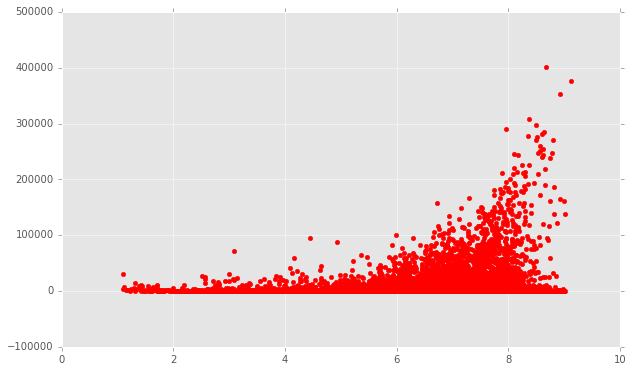

In [264]:
%matplotlib inline

plt.figure(figsize=(10, 6))
plt.scatter(rating, X.kp_rating_count, color='red')

Видим, что рейтинг популярности имеет значительную зависимость с целевой переменной. Об этом может свидетельствовать характерное смещение на графике. Но это касается в большей степени фильмов рейтинг, которых $~> 6$.

In [269]:
X = train.budget.dropna()

In [297]:
import re

money = []
for cash in X:
    valid = re.sub('[^0-9]+', '', cash)
    money.append(int(valid))

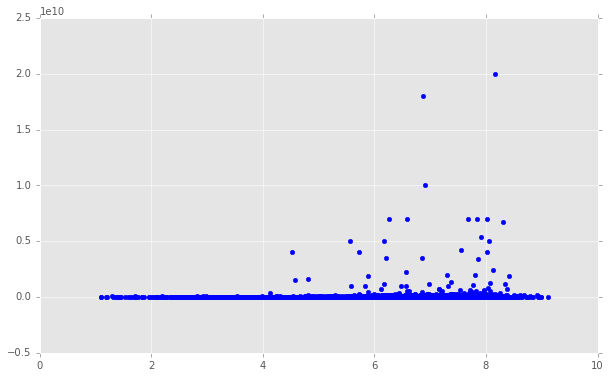

In [301]:
plt.figure(figsize=(10, 6))
plt.scatter(rating[X.index], money, color='blue')

А вот от бюджета мало что зависит. Здесь не видно никакой корреляции. Это и понятно -- зрителя же не обманешь.

**2. Посмотрим какие жанры фильмов чаще всего встречаются вместе. Построим Heatmap диаграмму.**

In [303]:
X = train.genres.dropna()

In [320]:
import nltk

words = nltk.word_tokenize(str(list(X)))
genres = list(set([word for word in words if len(word) > 3]))

In [321]:
genres

['семейный',
 'ток-шоу',
 'аниме',
 'боевик',
 'спорт',
 'фэнтези',
 'документальный',
 'фильм-нуар',
 'мультфильм',
 'музыка',
 'криминал',
 'фантастика',
 'короткометражка',
 'история',
 'триллер',
 'мелодрама',
 'приключения',
 'игра',
 'новости',
 'взрослых',
 'реальное',
 'вестерн',
 'мюзикл',
 'ужасы',
 'драма',
 'концерт',
 'детектив',
 'биография',
 'военный',
 'детский',
 'комедия',
 'церемония']

Построим матрицу встречаемости жанров

In [327]:
m = len(genres)
matrix = np.zeros((m, m))
for s, genre in enumerate(genres):
    for t, g in enumerate(genres):
        for i in range(len(X)):
            if g in X.iloc[i] and genre in X.iloc[i]:
                matrix[s, t]+=1          

Строим Heatmap диаграмму

In [368]:
# чтобы был русский шрифт
from matplotlib import rc
 
font = {'family': 'Verdana',
        'weight': 'normal'}
rc('font', **font)

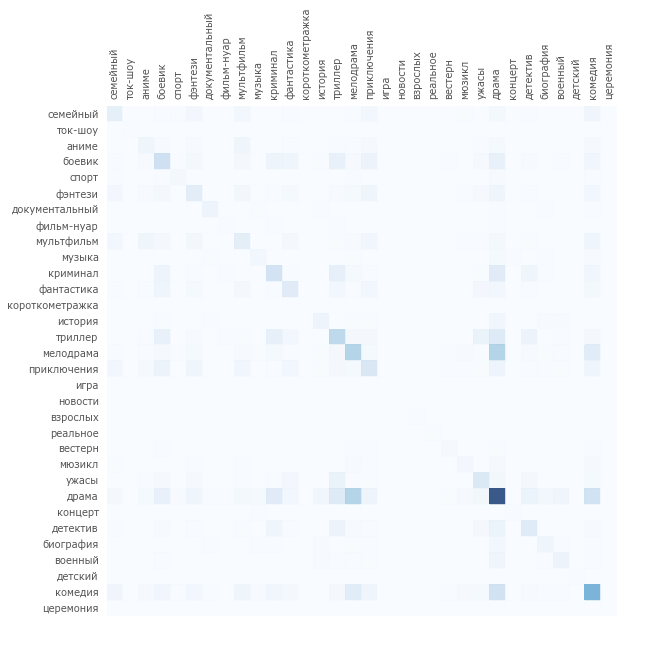

In [378]:
fig, ax = plt.subplots()
plt.pcolor(matrix, cmap=plt.cm.Blues, alpha=0.8)

ax.set_frame_on(False)
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.set_yticks(np.arange(32) + 0.5, minor=False)
ax.set_xticks(np.arange(32) + 0.5, minor=False)

fig = plt.gcf()
fig.set_size_inches(10,10)

plt.xticks(rotation=90)

ax.set_xticklabels(genres, minor=False) 
ax.set_yticklabels(genres, minor=False)

ax = plt.gca()
for t in ax.xaxis.get_major_ticks(): 
    t.tick1On = False 
    t.tick2On = False 
for t in ax.yaxis.get_major_ticks(): 
    t.tick1On = False 
    t.tick2On = False  

Похоже на правду. Заметим, что, например, тэг Драма часто встречается с тэгом Мелодрама, а Анимэ -- с Мультфильмами.